In [29]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
import tqdm  
import scipy
import skimage
from skimage.transform import resize

In [9]:
print(os.listdir("chest_xray/"))

['.DS_Store', 'test', 'train', 'val']


In [10]:
print(os.listdir("chest_xray/train/"))

['.DS_Store', 'NORMAL', 'PNEUMONIA']


In [12]:
print(os.listdir("chest_xray/test/"))

['.DS_Store', 'NORMAL', 'PNEUMONIA']


In [109]:
TRAIN_DIR = "chest_xray/train/"
TEST_DIR = "chest_xray/test/"
TEST_VAL = "chest_xray/val"

In [14]:
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
    return nextdir, label

In [15]:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (150, 150, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [42]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm.tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [43]:
X_train, y_train = get_data(TRAIN_DIR)

100%|██████████████████████████████████████████████████████████████████████████████| 3876/3876 [12:50<00:00,  5.03it/s]


In [44]:
X_test , y_test = get_data(TEST_DIR)

100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:00<00:00,  6.45it/s]


In [45]:
print(X_train.shape,'\n',X_test.shape)

(5216, 150, 150, 3) 
 (624, 150, 150, 3)


In [46]:
print(y_train.shape,'\n',y_test.shape)

(5216,) 
 (624,)


In [47]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

Using TensorFlow backend.


In [48]:
Pimages = os.listdir(TRAIN_DIR + "PNEUMONIA")
Nimages = os.listdir(TRAIN_DIR + "NORMAL")

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


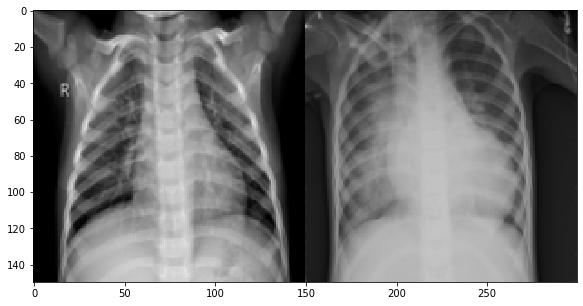

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


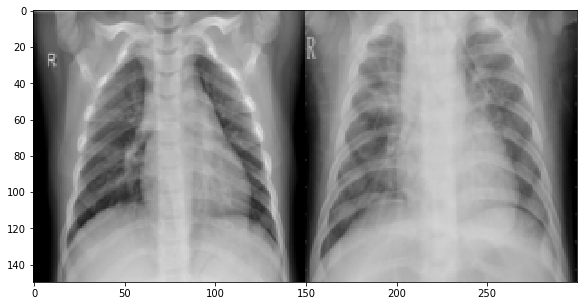

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


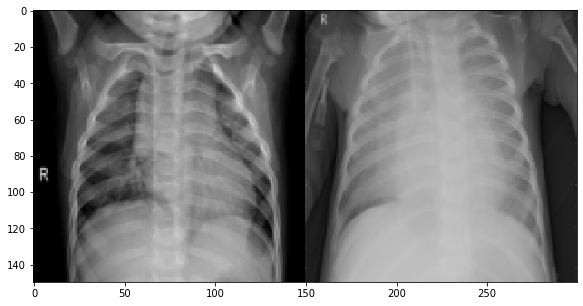

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


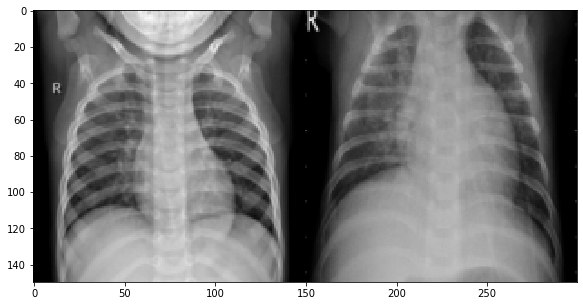

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


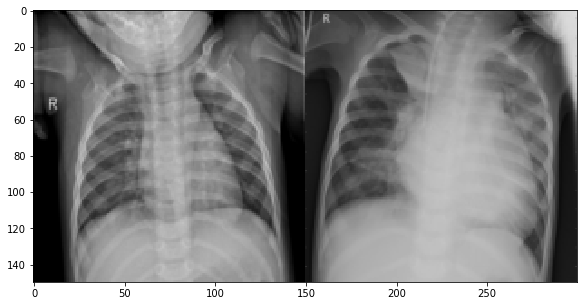

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
def plotter(i):
    imagep1 = cv2.imread(TRAIN_DIR+"PNEUMONIA/"+Pimages[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread(TRAIN_DIR+"NORMAL/"+Nimages[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("(Left) - No Pneumonia Vs (Right) - Pneumonia")
    print("-----------------------------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(5,10):
    plotter(i)

In [51]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

C:\Users\kkopperla\AppData\Local\Continuum\anaconda2\envs\py37\lib\site-packages\keras\callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [52]:

filepath="transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [59]:
from keras.models import Sequential , Model
from keras.layers import Dense , Activation
from keras.layers import Dropout , GlobalAveragePooling2D
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.tensorflow_backend.set_image_dim_ordering('th')
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [58]:
X_train=X_train.reshape(5216,3,150,150)
X_test=X_test.reshape(624,3,150,150)

In [81]:
from keras.applications.inception_v3 import InceptionV3
# create the base pre-trained model
base_model = InceptionV3(weights=None, include_top=False , input_shape=(3, 150, 150))

In [82]:
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='sigmoid')(x)

In [83]:
base_model.load_weights("inception_v3_weights.h5")

In [84]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

In [86]:
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 3, 150, 150)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 32, 74, 74)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, 32, 74, 74)   96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 32, 74, 74)   0           batch_normalization_96[0][0]     
____________________________________________________________________________________________

__________________________________________________________________________________________________
mixed0 (Concatenate)            (None, 256, 16, 16)  0           activation_100[0][0]             
                                                                 activation_102[0][0]             
                                                                 activation_105[0][0]             
                                                                 activation_106[0][0]             
__________________________________________________________________________________________________
conv2d_110 (Conv2D)             (None, 64, 16, 16)   16384       mixed0[0][0]                     
__________________________________________________________________________________________________
batch_normalization_111 (BatchN (None, 64, 16, 16)   192         conv2d_110[0][0]                 
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
batch_normalization_115 (BatchN (None, 64, 16, 16)   192         conv2d_114[0][0]                 
__________________________________________________________________________________________________
batch_normalization_117 (BatchN (None, 64, 16, 16)   192         conv2d_116[0][0]                 
__________________________________________________________________________________________________
batch_normalization_120 (BatchN (None, 96, 16, 16)   288         conv2d_119[0][0]                 
__________________________________________________________________________________________________
batch_normalization_121 (BatchN (None, 64, 16, 16)   192         conv2d_120[0][0]                 
__________________________________________________________________________________________________
activation_114 (Activation)     (None, 64, 16, 16)   0           batch_normalization_115[0][0]    
__________

batch_normalization_133 (BatchN (None, 128, 7, 7)    384         conv2d_132[0][0]                 
__________________________________________________________________________________________________
activation_127 (Activation)     (None, 128, 7, 7)    0           batch_normalization_128[0][0]    
__________________________________________________________________________________________________
activation_132 (Activation)     (None, 128, 7, 7)    0           batch_normalization_133[0][0]    
__________________________________________________________________________________________________
average_pooling2d_13 (AveragePo (None, 768, 7, 7)    0           mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_125 (Conv2D)             (None, 192, 7, 7)    147456      mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_128

__________________________________________________________________________________________________
batch_normalization_136 (BatchN (None, 192, 7, 7)    576         conv2d_135[0][0]                 
__________________________________________________________________________________________________
batch_normalization_139 (BatchN (None, 192, 7, 7)    576         conv2d_138[0][0]                 
__________________________________________________________________________________________________
batch_normalization_144 (BatchN (None, 192, 7, 7)    576         conv2d_143[0][0]                 
__________________________________________________________________________________________________
batch_normalization_145 (BatchN (None, 192, 7, 7)    576         conv2d_144[0][0]                 
__________________________________________________________________________________________________
activation_135 (Activation)     (None, 192, 7, 7)    0           batch_normalization_136[0][0]    
__________

activation_154 (Activation)     (None, 192, 7, 7)    0           batch_normalization_155[0][0]    
__________________________________________________________________________________________________
mixed6 (Concatenate)            (None, 768, 7, 7)    0           activation_145[0][0]             
                                                                 activation_148[0][0]             
                                                                 activation_153[0][0]             
                                                                 activation_154[0][0]             
__________________________________________________________________________________________________
conv2d_159 (Conv2D)             (None, 192, 7, 7)    147456      mixed6[0][0]                     
__________________________________________________________________________________________________
batch_normalization_160 (BatchN (None, 192, 7, 7)    576         conv2d_159[0][0]                 
__________

batch_normalization_169 (BatchN (None, 192, 7, 7)    576         conv2d_168[0][0]                 
__________________________________________________________________________________________________
activation_168 (Activation)     (None, 192, 7, 7)    0           batch_normalization_169[0][0]    
__________________________________________________________________________________________________
conv2d_165 (Conv2D)             (None, 192, 7, 7)    147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_169 (Conv2D)             (None, 192, 7, 7)    258048      activation_168[0][0]             
__________________________________________________________________________________________________
batch_normalization_166 (BatchN (None, 192, 7, 7)    576         conv2d_165[0][0]                 
__________________________________________________________________________________________________
batch_norm

activation_178 (Activation)     (None, 384, 3, 3)    0           batch_normalization_179[0][0]    
__________________________________________________________________________________________________
batch_normalization_180 (BatchN (None, 192, 3, 3)    576         conv2d_179[0][0]                 
__________________________________________________________________________________________________
activation_171 (Activation)     (None, 320, 3, 3)    0           batch_normalization_172[0][0]    
__________________________________________________________________________________________________
mixed9_0 (Concatenate)          (None, 768, 3, 3)    0           activation_173[0][0]             
                                                                 activation_174[0][0]             
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 768, 3, 3)    0           activation_177[0][0]             
          

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_4[0][0]              
                                                                 activation_188[0][0]             
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048, 3, 3)   0           mixed10[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_2 (Glo (None, 2048)         0           dropout_2[0][0]                  
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          262272      global_average_pooling2d_2[0][0] 
__________________________________________________________________________________________________
batch_norm

In [88]:
batch_size = 64
epochs = 10

In [89]:
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint], epochs=epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5216 samples, validate on 624 samples
Epoch 1/10
5216/5216 [==============================] - ETA: 1:30:58 - loss: 0.7301 - acc: 0.62 - ETA: 52:04 - loss: 0.7273 - acc: 0.6250 - ETA: 39:28 - loss: 0.7155 - acc: 0.66 - ETA: 33:02 - loss: 0.7020 - acc: 0.69 - ETA: 29:22 - loss: 0.6740 - acc: 0.71 - ETA: 26:52 - loss: 0.6388 - acc: 0.70 - ETA: 25:13 - loss: 0.6512 - acc: 0.70 - ETA: 23:49 - loss: 0.6372 - acc: 0.71 - ETA: 22:41 - loss: 0.6062 - acc: 0.73 - ETA: 21:45 - loss: 0.5781 - acc: 0.74 - ETA: 20:58 - loss: 0.5489 - acc: 0.76 - ETA: 20:25 - loss: 0.5305 - acc: 0.77 - ETA: 19:49 - loss: 0.5094 - acc: 0.78 - ETA: 19:15 - loss: 0.4982 - acc: 0.79 - ETA: 18:43 - loss: 0.4780 - acc: 0.80 - ETA: 18:15 - loss: 0.4673 - acc: 0.80 - ETA: 17:52 - loss: 0.4564 - acc: 0.81 - ETA: 17:31 - loss: 0.4516 - acc: 0.81 - ETA: 17:11 - loss: 0.4429 - acc: 0.81 - ETA: 16:58 - loss: 0.4328 - acc: 0.82 -

5216/5216 [==============================] - ETA: 15:13 - loss: 0.0831 - acc: 0.96 - ETA: 15:00 - loss: 0.1623 - acc: 0.93 - ETA: 15:04 - loss: 0.1496 - acc: 0.93 - ETA: 14:55 - loss: 0.1326 - acc: 0.94 - ETA: 14:52 - loss: 0.1466 - acc: 0.95 - ETA: 15:01 - loss: 0.1310 - acc: 0.95 - ETA: 14:48 - loss: 0.1337 - acc: 0.95 - ETA: 14:40 - loss: 0.1355 - acc: 0.94 - ETA: 14:33 - loss: 0.1344 - acc: 0.95 - ETA: 14:22 - loss: 0.1284 - acc: 0.95 - ETA: 14:15 - loss: 0.1262 - acc: 0.95 - ETA: 14:12 - loss: 0.1201 - acc: 0.95 - ETA: 14:05 - loss: 0.1170 - acc: 0.95 - ETA: 14:00 - loss: 0.1141 - acc: 0.95 - ETA: 13:55 - loss: 0.1224 - acc: 0.95 - ETA: 13:48 - loss: 0.1186 - acc: 0.95 - ETA: 13:44 - loss: 0.1295 - acc: 0.95 - ETA: 13:42 - loss: 0.1365 - acc: 0.95 - ETA: 13:35 - loss: 0.1306 - acc: 0.95 - ETA: 13:30 - loss: 0.1344 - acc: 0.95 - ETA: 13:23 - loss: 0.1298 - acc: 0.95 - ETA: 13:18 - loss: 0.1252 - acc: 0.95 - ETA: 13:12 - loss: 0.1243 - acc: 0.95 - ETA: 13:06 - loss: 0.1213 - acc: 0.

5216/5216 [==============================] - ETA: 15:30 - loss: 0.1781 - acc: 0.93 - ETA: 15:59 - loss: 0.1262 - acc: 0.96 - ETA: 16:01 - loss: 0.1135 - acc: 0.96 - ETA: 16:02 - loss: 0.1164 - acc: 0.96 - ETA: 16:05 - loss: 0.1226 - acc: 0.96 - ETA: 15:53 - loss: 0.1069 - acc: 0.97 - ETA: 15:51 - loss: 0.1012 - acc: 0.96 - ETA: 15:48 - loss: 0.1305 - acc: 0.95 - ETA: 15:45 - loss: 0.1248 - acc: 0.95 - ETA: 15:52 - loss: 0.1149 - acc: 0.95 - ETA: 15:50 - loss: 0.1123 - acc: 0.95 - ETA: 15:50 - loss: 0.1053 - acc: 0.95 - ETA: 15:43 - loss: 0.1024 - acc: 0.95 - ETA: 15:33 - loss: 0.1023 - acc: 0.95 - ETA: 15:26 - loss: 0.1080 - acc: 0.95 - ETA: 15:14 - loss: 0.1039 - acc: 0.96 - ETA: 15:04 - loss: 0.1039 - acc: 0.96 - ETA: 14:55 - loss: 0.1013 - acc: 0.96 - ETA: 14:44 - loss: 0.0995 - acc: 0.96 - ETA: 14:34 - loss: 0.0967 - acc: 0.96 - ETA: 14:26 - loss: 0.1012 - acc: 0.96 - ETA: 14:19 - loss: 0.0993 - acc: 0.96 - ETA: 14:11 - loss: 0.0973 - acc: 0.96 - ETA: 14:03 - loss: 0.1007 - acc: 0.

5216/5216 [==============================] - ETA: 17:08 - loss: 0.0123 - acc: 1.00 - ETA: 16:17 - loss: 0.0263 - acc: 0.98 - ETA: 15:53 - loss: 0.0347 - acc: 0.97 - ETA: 16:26 - loss: 0.0413 - acc: 0.98 - ETA: 16:12 - loss: 0.0452 - acc: 0.98 - ETA: 16:05 - loss: 0.0535 - acc: 0.97 - ETA: 16:01 - loss: 0.0592 - acc: 0.97 - ETA: 15:53 - loss: 0.0544 - acc: 0.97 - ETA: 15:55 - loss: 0.0567 - acc: 0.97 - ETA: 15:49 - loss: 0.0533 - acc: 0.97 - ETA: 15:46 - loss: 0.0584 - acc: 0.97 - ETA: 15:45 - loss: 0.0557 - acc: 0.97 - ETA: 15:41 - loss: 0.0769 - acc: 0.97 - ETA: 15:42 - loss: 0.0741 - acc: 0.97 - ETA: 15:41 - loss: 0.0741 - acc: 0.97 - ETA: 15:40 - loss: 0.0725 - acc: 0.97 - ETA: 15:38 - loss: 0.0708 - acc: 0.97 - ETA: 15:39 - loss: 0.0688 - acc: 0.97 - ETA: 15:40 - loss: 0.0660 - acc: 0.97 - ETA: 15:35 - loss: 0.0649 - acc: 0.97 - ETA: 15:31 - loss: 0.0650 - acc: 0.97 - ETA: 15:23 - loss: 0.0637 - acc: 0.97 - ETA: 15:17 - loss: 0.0618 - acc: 0.97 - ETA: 15:07 - loss: 0.0599 - acc: 0.

5216/5216 [==============================] - ETA: 15:11 - loss: 0.0347 - acc: 1.00 - ETA: 15:44 - loss: 0.0528 - acc: 0.96 - ETA: 15:29 - loss: 0.0388 - acc: 0.97 - ETA: 15:12 - loss: 0.0316 - acc: 0.98 - ETA: 15:21 - loss: 0.0335 - acc: 0.98 - ETA: 15:17 - loss: 0.0401 - acc: 0.98 - ETA: 15:07 - loss: 0.0373 - acc: 0.98 - ETA: 15:02 - loss: 0.0342 - acc: 0.98 - ETA: 14:52 - loss: 0.0331 - acc: 0.98 - ETA: 14:45 - loss: 0.0374 - acc: 0.98 - ETA: 14:39 - loss: 0.0390 - acc: 0.98 - ETA: 14:29 - loss: 0.0372 - acc: 0.98 - ETA: 14:30 - loss: 0.0387 - acc: 0.98 - ETA: 14:28 - loss: 0.0391 - acc: 0.98 - ETA: 14:26 - loss: 0.0398 - acc: 0.98 - ETA: 14:24 - loss: 0.0403 - acc: 0.98 - ETA: 14:25 - loss: 0.0387 - acc: 0.98 - ETA: 14:27 - loss: 0.0379 - acc: 0.98 - ETA: 14:30 - loss: 0.0389 - acc: 0.98 - ETA: 14:27 - loss: 0.0388 - acc: 0.98 - ETA: 14:34 - loss: 0.0377 - acc: 0.98 - ETA: 14:35 - loss: 0.0369 - acc: 0.98 - ETA: 14:37 - loss: 0.0416 - acc: 0.98 - ETA: 14:38 - loss: 0.0402 - acc: 0.

5216/5216 [==============================] - ETA: 16:44 - loss: 0.0400 - acc: 0.96 - ETA: 16:13 - loss: 0.1279 - acc: 0.95 - ETA: 15:58 - loss: 0.0956 - acc: 0.96 - ETA: 15:51 - loss: 0.0742 - acc: 0.97 - ETA: 15:41 - loss: 0.0621 - acc: 0.98 - ETA: 15:26 - loss: 0.0555 - acc: 0.98 - ETA: 15:21 - loss: 0.0483 - acc: 0.98 - ETA: 15:11 - loss: 0.0436 - acc: 0.98 - ETA: 15:03 - loss: 0.0599 - acc: 0.97 - ETA: 15:03 - loss: 0.0637 - acc: 0.97 - ETA: 14:57 - loss: 0.0615 - acc: 0.97 - ETA: 14:53 - loss: 0.0595 - acc: 0.97 - ETA: 14:48 - loss: 0.0583 - acc: 0.97 - ETA: 14:39 - loss: 0.0595 - acc: 0.97 - ETA: 14:33 - loss: 0.0564 - acc: 0.97 - ETA: 14:26 - loss: 0.0534 - acc: 0.97 - ETA: 14:19 - loss: 0.0509 - acc: 0.97 - ETA: 14:13 - loss: 0.0494 - acc: 0.98 - ETA: 14:06 - loss: 0.0472 - acc: 0.98 - ETA: 13:58 - loss: 0.0463 - acc: 0.98 - ETA: 13:53 - loss: 0.0490 - acc: 0.98 - ETA: 13:52 - loss: 0.0473 - acc: 0.98 - ETA: 13:50 - loss: 0.0462 - acc: 0.98 - ETA: 13:44 - loss: 0.0467 - acc: 0.

5216/5216 [==============================] - ETA: 14:38 - loss: 0.0872 - acc: 0.96 - ETA: 14:57 - loss: 0.0687 - acc: 0.96 - ETA: 15:04 - loss: 0.0670 - acc: 0.96 - ETA: 15:07 - loss: 0.0517 - acc: 0.97 - ETA: 15:03 - loss: 0.0435 - acc: 0.98 - ETA: 14:58 - loss: 0.0382 - acc: 0.98 - ETA: 14:56 - loss: 0.0467 - acc: 0.98 - ETA: 14:57 - loss: 0.0436 - acc: 0.98 - ETA: 14:53 - loss: 0.0402 - acc: 0.98 - ETA: 14:51 - loss: 0.0392 - acc: 0.98 - ETA: 14:47 - loss: 0.0390 - acc: 0.98 - ETA: 14:42 - loss: 0.0398 - acc: 0.98 - ETA: 14:38 - loss: 0.0391 - acc: 0.98 - ETA: 14:36 - loss: 0.0371 - acc: 0.98 - ETA: 14:36 - loss: 0.0380 - acc: 0.98 - ETA: 14:39 - loss: 0.0383 - acc: 0.98 - ETA: 14:35 - loss: 0.0377 - acc: 0.98 - ETA: 14:30 - loss: 0.0398 - acc: 0.98 - ETA: 14:23 - loss: 0.0403 - acc: 0.98 - ETA: 14:15 - loss: 0.0406 - acc: 0.98 - ETA: 14:09 - loss: 0.0389 - acc: 0.98 - ETA: 14:01 - loss: 0.0386 - acc: 0.99 - ETA: 13:53 - loss: 0.0589 - acc: 0.98 - ETA: 13:48 - loss: 0.0595 - acc: 0.

5216/5216 [==============================] - ETA: 16:53 - loss: 0.0290 - acc: 1.00 - ETA: 16:18 - loss: 0.0344 - acc: 1.00 - ETA: 16:00 - loss: 0.0351 - acc: 1.00 - ETA: 15:53 - loss: 0.0363 - acc: 1.00 - ETA: 15:45 - loss: 0.0333 - acc: 1.00 - ETA: 15:39 - loss: 0.0418 - acc: 0.98 - ETA: 15:36 - loss: 0.0385 - acc: 0.99 - ETA: 15:33 - loss: 0.0346 - acc: 0.99 - ETA: 15:28 - loss: 0.0336 - acc: 0.99 - ETA: 15:18 - loss: 0.0314 - acc: 0.99 - ETA: 15:10 - loss: 0.0291 - acc: 0.99 - ETA: 15:06 - loss: 0.0279 - acc: 0.99 - ETA: 14:57 - loss: 0.0283 - acc: 0.99 - ETA: 14:50 - loss: 0.0274 - acc: 0.99 - ETA: 14:44 - loss: 0.0266 - acc: 0.99 - ETA: 14:35 - loss: 0.0258 - acc: 0.99 - ETA: 14:32 - loss: 0.0258 - acc: 0.99 - ETA: 14:25 - loss: 0.0253 - acc: 0.99 - ETA: 14:18 - loss: 0.0254 - acc: 0.99 - ETA: 14:12 - loss: 0.0248 - acc: 0.99 - ETA: 14:04 - loss: 0.0247 - acc: 0.99 - ETA: 13:57 - loss: 0.0246 - acc: 0.99 - ETA: 13:54 - loss: 0.0291 - acc: 0.99 - ETA: 13:48 - loss: 0.0288 - acc: 0.

5216/5216 [==============================] - ETA: 15:34 - loss: 0.0071 - acc: 1.00 - ETA: 15:47 - loss: 0.0211 - acc: 1.00 - ETA: 15:29 - loss: 0.0204 - acc: 1.00 - ETA: 15:30 - loss: 0.0200 - acc: 1.00 - ETA: 15:21 - loss: 0.0245 - acc: 1.00 - ETA: 15:14 - loss: 0.0353 - acc: 0.99 - ETA: 15:13 - loss: 0.0353 - acc: 0.99 - ETA: 15:03 - loss: 0.0348 - acc: 0.99 - ETA: 15:01 - loss: 0.0328 - acc: 0.99 - ETA: 14:54 - loss: 0.0311 - acc: 0.99 - ETA: 14:49 - loss: 0.0441 - acc: 0.99 - ETA: 14:45 - loss: 0.0430 - acc: 0.99 - ETA: 14:38 - loss: 0.0408 - acc: 0.99 - ETA: 14:29 - loss: 0.0443 - acc: 0.99 - ETA: 14:24 - loss: 0.0452 - acc: 0.98 - ETA: 14:17 - loss: 0.0461 - acc: 0.98 - ETA: 14:09 - loss: 0.0439 - acc: 0.98 - ETA: 14:02 - loss: 0.0429 - acc: 0.98 - ETA: 13:55 - loss: 0.0426 - acc: 0.99 - ETA: 13:49 - loss: 0.0439 - acc: 0.98 - ETA: 13:45 - loss: 0.0486 - acc: 0.98 - ETA: 13:38 - loss: 0.0556 - acc: 0.98 - ETA: 13:33 - loss: 0.0544 - acc: 0.98 - ETA: 13:25 - loss: 0.0546 - acc: 0.

5216/5216 [==============================] - ETA: 14:59 - loss: 0.0206 - acc: 1.00 - ETA: 14:46 - loss: 0.0217 - acc: 1.00 - ETA: 14:59 - loss: 0.0241 - acc: 1.00 - ETA: 14:51 - loss: 0.0311 - acc: 0.99 - ETA: 14:51 - loss: 0.0329 - acc: 0.98 - ETA: 14:53 - loss: 0.0381 - acc: 0.98 - ETA: 14:43 - loss: 0.0390 - acc: 0.98 - ETA: 14:45 - loss: 0.0428 - acc: 0.98 - ETA: 14:40 - loss: 0.0609 - acc: 0.97 - ETA: 14:29 - loss: 0.0553 - acc: 0.97 - ETA: 14:27 - loss: 0.0551 - acc: 0.97 - ETA: 14:23 - loss: 0.0523 - acc: 0.97 - ETA: 14:15 - loss: 0.0501 - acc: 0.98 - ETA: 14:10 - loss: 0.0483 - acc: 0.98 - ETA: 14:06 - loss: 0.0490 - acc: 0.98 - ETA: 14:00 - loss: 0.0484 - acc: 0.98 - ETA: 13:55 - loss: 0.0460 - acc: 0.98 - ETA: 13:48 - loss: 0.0453 - acc: 0.98 - ETA: 13:43 - loss: 0.0432 - acc: 0.98 - ETA: 13:37 - loss: 0.0438 - acc: 0.98 - ETA: 13:30 - loss: 0.0425 - acc: 0.98 - ETA: 13:24 - loss: 0.0412 - acc: 0.98 - ETA: 13:18 - loss: 0.0404 - acc: 0.98 - ETA: 13:12 - loss: 0.0414 - acc: 0.

In [90]:
model.load_weights("transferlearning_weights.hdf5")

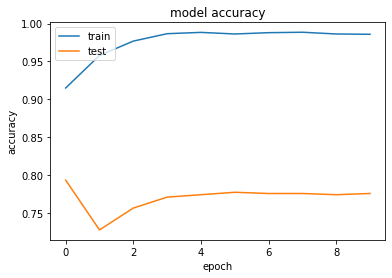

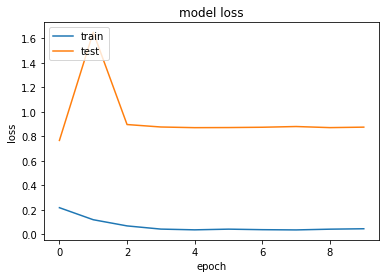

In [91]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [92]:

from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

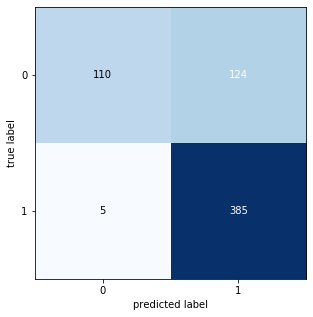

In [94]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [96]:
#Precission

385 / (385 + 124)

0.756385068762279

In [97]:
#Recall
385 / (385 + 5)

0.9871794871794872

In [110]:
from keras.preprocessing.image import ImageDataGenerator
rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = 'categorical'

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    TEST_VAL,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

Found 16 images belonging to 2 classes.


In [111]:

import matplotlib.image as mpimg

y_pred_batches = []
y_true_batches = []
y_img_batches = []

for i in range(0, len(test_generator)):
  y_img_batch, y_true_batch = test_generator[i]
  y_true_batch = y_true_batch.argmax(axis=-1)
  y_img_batches.append(y_img_batch)
  y_true_batches.append(y_true_batch)

  y_pred_batch = model.predict(y_img_batch)
  y_pred_batch = y_pred_batch.argmax(axis=-1)
  y_pred_batches.append(y_pred_batch)

y_pred_batches


[array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64)]

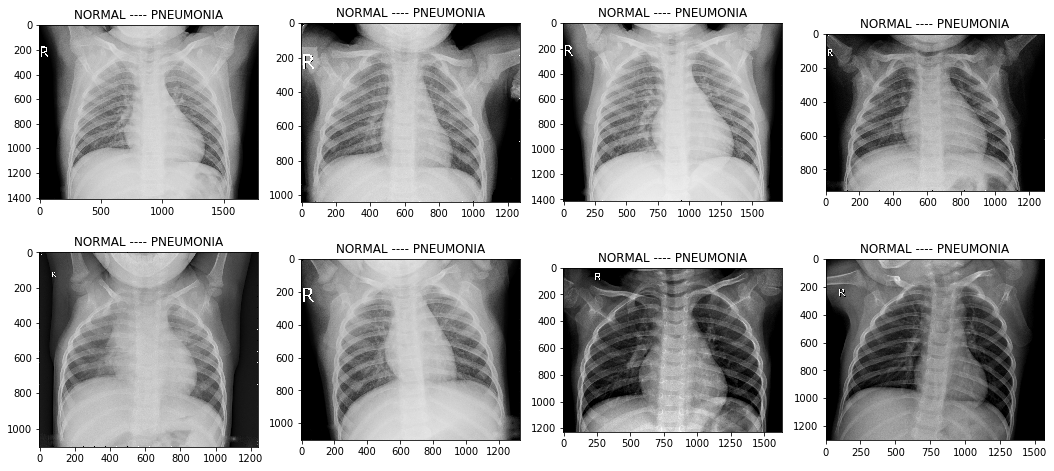

In [112]:
def show_prediction(images_path, label):
  amount = 0
  fig = plt.figure(figsize=(18, 8))

  for file in os.listdir(images_path):
    if file.endswith('.jpeg'):
      if amount == 9:
        break

      img = mpimg.imread(os.path.join(images_path, file))
      plt.subplot(241+amount)
      plt.title('{} ---- {}'.format(label, 'NORMAL' if y_pred_batches[amount] == 0 else 'PNEUMONIA'))
      imgplot = plt.imshow(img, cmap='gray', vmin=0, vmax=255)

      amount += 1
show_prediction('chest_xray/val/NORMAL', 'NORMAL')

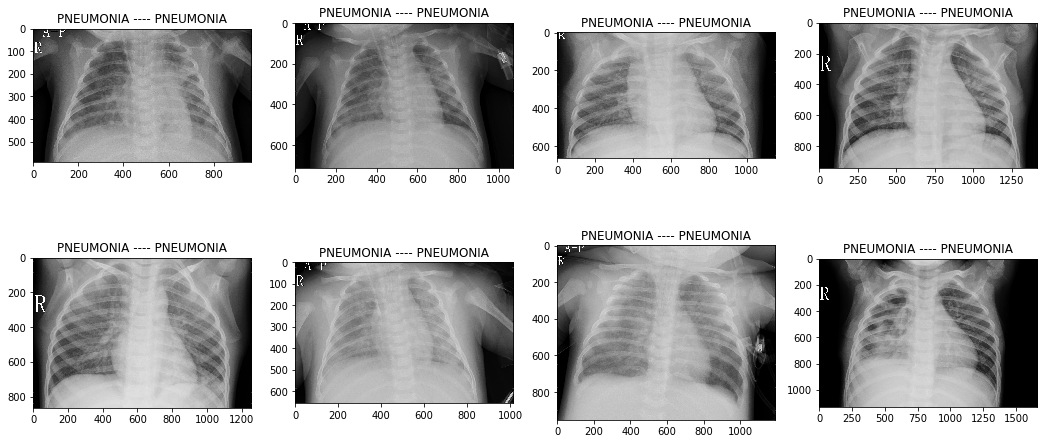

In [113]:
show_prediction('chest_xray/val/PNEUMONIA', 'PNEUMONIA')